In [52]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf 

N = scipy.stats.norm.cdf
n = scipy.stats.norm.pdf
sns.set_style("darkgrid")

np.random.seed(1)

Laboratory Assignments:

1.1: Implement delta-hedging for a simulated price trajectory and show that the cost of the hedge approaches zero as the frequency of rehedging increases to infinity.

1.2: Implement delta-gamma-hedging (a chosen variant) for a simulated price trajectory. Show that the cost is lower than that of the delta-hedge. Use the following condition for the second option strike: K2>K for call and K2<K for put.

1.3: Hedge funds use delta-hedging to minimize risk when trading options. Implement hedging strategies for a selected stock (APPLE, TESLA, KGHM, ASML) - use Black-Scholes formula to calculate option prices and greeks

General setup:
We sell an option (call) -> short position
We want to hedge the risk using Δ-hedging strategy
Remarks:
We need to have a price trajectory -> simulate it using GBM
We need to have the option premium at t=0 -> calculate it using the Black-Scholes price formula
We need Δ_t at each moment of rehedging -> calculate it using the formula for Δ in the Black-Scholes setup
The strategy outcome is random (dependent on a given price trajectory)
Repeat the procedure many times (with different realizations of GBM) and analyse the outcome distribution (pdf, mean, etc.)
Repeat the simulations for different rehedging frequency

In [53]:
class GBM():
    
    def __init__(self, sigma, mu, S0, T=2, dt=0.01):
        
        self.sigma = sigma
        self.mu = mu
        self.S0 = S0
        self.T = T
        self.dt = dt 
        
        norm = scipy.stats.norm.rvs(0, np.sqrt(dt), size = int(round(T/dt))) 
        Wt = np.cumsum(norm) #brownian motion
        
        self.trajectory = np.concatenate([np.array([self.S0]), self.S0*np.exp((mu-(self.sigma**2)/2)*np.arange(dt, T, step=dt) + self.sigma*Wt[:-1])])
                
    def plot(self):
        
        plt.plot(np.arange(self.T, step = self.dt), self.trajectory)
        plt.xlabel("t")
        plt.ylabel("S(t)")
        plt.show()
        
class RealData():
    
    def __init__(self, df, mu):

        df["Returns"] = df["Close"]/df["Close"].shift(1)
        df["Log_returns"] = np.log(df["Returns"])
        df = df.iloc[1:] #return for the first row is not known
        
        self.sigma = np.std(df["Log_returns"])*np.sqrt(251)
        self.mu = mu
        self.T = 1
        self.dt = 1/251
        self.data_frame = df
        self.dates = np.array(df.index.strftime('%Y-%m-%d'))
        
        self.trajectory = np.array(df["Close"])
        
    def plot(self):
        
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) 
        plt.gcf().autofmt_xdate()
        plt.plot(self.dates, self.trajectory)
        plt.xlabel("t")
        plt.ylabel("S(t)")
        plt.show()
                      
class Option():
    
    def __init__(self, K, brownian_motion, option_type):
        
        self.K = K
        self.brownian_motion = brownian_motion  
        self.r = self.brownian_motion.mu 
        self.option_type = option_type
        
    def d1(self, t):
        return (np.log(self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))]/self.K) + (self.r + (self.brownian_motion.sigma)**2/2)*(self.brownian_motion.T - t)) / (self.brownian_motion.sigma*np.sqrt(self.brownian_motion.T - t))
     
    def d2(self, t):
        return self.d1(t) - self.brownian_motion.sigma * np.sqrt(self.brownian_motion.T - t)       
        
    def price_option(self, t=0):
        
        if self.option_type == "call":
            return self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))] * N(self.d1(t)) - self.K * np.exp(-self.r*(self.brownian_motion.T-t))* N(self.d2(t))
        elif self.option_type == "put":
            return self.K*np.exp(-self.r*(self.brownian_motion.T-t))*N(-self.d2(t)) - self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))]*N(-self.d1(t))

    def delta(self, t=0):
        
        if self.option_type == "call":
            return N(self.d1(t))
        
        elif self.option_type == "put":
            return N(self.d1(t)) - 1
        
    def gamma(self, t=0):
        
        return n(self.d1(t))/(self.brownian_motion.trajectory[int(round(t/self.brownian_motion.dt))]*self.brownian_motion.sigma*np.sqrt(self.brownian_motion.T - t))
    
    def payoff(self):
        
        if self.option_type == "call":
            return np.max([self.brownian_motion.trajectory[-1] - self.K, 0])
        
        elif self.option_type == "put":
            return np.max([self.K - self.brownian_motion.trajectory[-1], 0])
        

### No hedging
----------------------

In [54]:
#no hedging

K = 110
r = 0.04
value_put_no_hedge = np.zeros(10000)
value_call_no_hedge = np.zeros(10000)
 
for mcs in np.arange(10000):
    gbm = GBM(0.2, 0.04, 100)  
    
    option_market_put = Option(K, gbm, "put")
    value_put_no_hedge[mcs] = np.exp(-option_market_put.r*gbm.T)*(((option_market_put.price_option())*np.exp(option_market_put.r*gbm.T) - option_market_put.payoff())/option_market_put.price_option())
    
    option_market_call = Option(K, gbm, "call")
    value_call_no_hedge[mcs] = np.exp(-option_market_call.r*gbm.T)*(((option_market_call.price_option())*np.exp(option_market_call.r*gbm.T) - option_market_call.payoff())/option_market_call.price_option())

Text(0.5, 1.0, 'Call option no hedging')

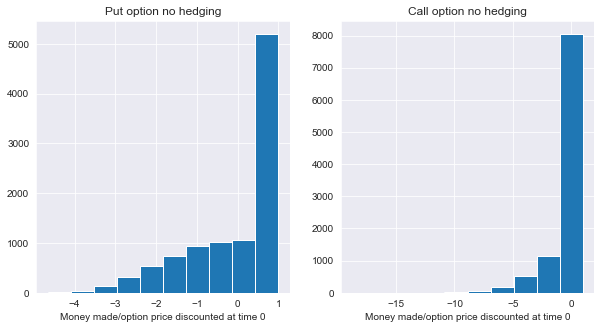

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(value_put_no_hedge)
ax1.set_xlabel("Money made/option price discounted at time 0")
ax1.set_title("Put option no hedging")

ax2.hist(value_call_no_hedge)
ax2.set_xlabel("Money made/option price discounted at time 0")
ax2.set_title("Call option no hedging")

In [56]:
print(f'Mean for put: {np.round(np.mean(value_put_no_hedge), 2)}.\nMean for call: {np.round(np.mean(value_call_no_hedge), 2)}.')
print(f'Variance for put: {np.round(np.var(value_put_no_hedge), 4)}.\nVariance for call: {np.round(np.var(value_call_no_hedge), 4)}.')

Mean for put: -0.0.
Mean for call: 0.01.
Variance for put: 1.4505.
Variance for call: 3.2666.


The mean money made/money spent for both put and call options is close to zero, as expected with correctly priced options. The maximum gain is capped at the option's price, while potential losses are unlimited, resulting in a left-skewed distribution. Variance is highest for the call option.

### Hedging at $t=0$
---------------------------------

In [57]:
#one hedging

K = 110
r = 0.04
value_put_one_hedge = np.zeros(1000)
value_call_one_hedge = np.zeros(1000)
 
for mcs in np.arange(1000):
    gbm = GBM(0.2, 0.04, 100)  
    option_market_put = Option(K, gbm, "put")
    value_put_one_hedge[mcs] = np.exp(-option_market_put.r*gbm.T)*(((option_market_put.price_option() - option_market_put.delta(0)*gbm.trajectory[0])*np.exp(option_market_put.r*gbm.T) + option_market_put.delta()*gbm.trajectory[-1] - option_market_put.payoff())/option_market_put.price_option())
    
    option_market_call = Option(K, gbm, "call")
    value_call_one_hedge[mcs] = np.exp(-option_market_call.r*gbm.T)*(((option_market_call.price_option() - option_market_call.delta(0)*gbm.trajectory[0])*np.exp(option_market_call.r*gbm.T) + option_market_call.delta()*gbm.trajectory[-1] - option_market_call.payoff())/option_market_call.price_option())

Text(0.5, 1.0, 'Call option one hedging')

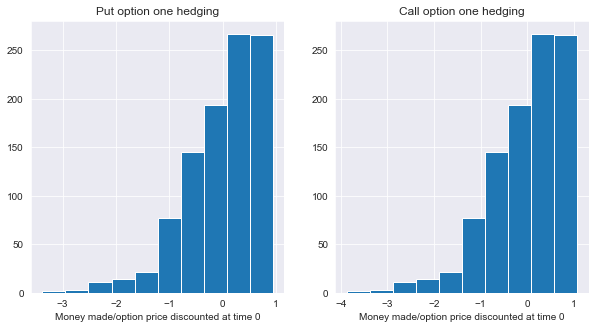

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(value_put_one_hedge)
ax1.set_xlabel("Money made/option price discounted at time 0")
ax1.set_title("Put option one hedging")

ax2.hist(value_call_one_hedge)
ax2.set_xlabel("Money made/option price discounted at time 0")
ax2.set_title("Call option one hedging")

In [59]:
print(f'Mean for put: {np.round(np.mean(value_put_one_hedge), 2)}.\nMean for call: {np.round(np.mean(value_call_one_hedge), 2)}.')
print(f'Variance for put: {np.round(np.var(value_put_one_hedge), 4)}.\nVariance for call: {np.round(np.var(value_call_one_hedge), 4)}.')

Mean for put: -0.01.
Mean for call: -0.01.
Variance for put: 0.4844.
Variance for call: 0.6359.


After hedging portoflio at $t=0$ variance has been reduced. Since the portfolio includes an asset, gains are not capped by the option's price, and due to delta hedging, losses have been limited.

### Hedging at $t=0$ and $t=1$
---------------------------------

In [60]:
#two hedgings

K = 110
r = 0.04
value_put_two_hedge = np.zeros(1000)
value_call_two_hedge = np.zeros(1000)
 
for mcs in np.arange(1000):
    gbm = GBM(0.2, 0.04, 100)  
    
    option_market_put = Option(K, gbm, "put") 
    assets_bought_compounded_put = option_market_put.delta(0)*gbm.trajectory[0]*np.exp(r*gbm.T) + (option_market_put.delta(1) - option_market_put.delta(0))*gbm.trajectory[int(np.round(1/gbm.dt))]*np.exp(r*(gbm.T-1))
    value_put_two_hedge[mcs] = np.exp(-r*gbm.T)*((option_market_put.price_option()*np.exp(option_market_put.r*gbm.T) - assets_bought_compounded_put + option_market_put.delta(1)*gbm.trajectory[-1] - option_market_put.payoff())/option_market_put.price_option())
    
    option_market_call = Option(K, gbm, "call")
    assets_bought_compounded_call = option_market_call.delta(0)*gbm.trajectory[0]*np.exp(r*gbm.T) + (option_market_call.delta(1) - option_market_call.delta(0))*gbm.trajectory[int(np.round(1/gbm.dt))]*np.exp(r*(gbm.T-1))
    value_call_two_hedge[mcs] = np.exp(-r*gbm.T)*((option_market_call.price_option()*np.exp(option_market_call.r*gbm.T) - assets_bought_compounded_call + option_market_call.delta(1)*gbm.trajectory[-1] - option_market_call.payoff())/option_market_call.price_option())

Text(0.5, 1.0, 'Call option two hedgings')

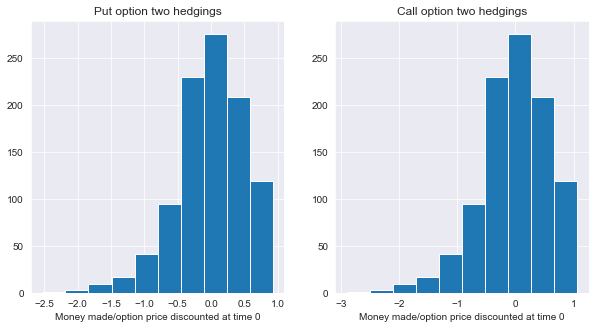

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(value_put_two_hedge)
ax1.set_xlabel("Money made/option price discounted at time 0")
ax1.set_title("Put option two hedgings")

ax2.hist(value_call_two_hedge)
ax2.set_xlabel("Money made/option price discounted at time 0")
ax2.set_title("Call option two hedgings")

In [62]:
print(f'Mean for put: {np.round(np.mean(value_put_two_hedge), 2)}.\nMean for call: {np.round(np.mean(value_call_two_hedge), 2)}.')
print(f'Variance for put: {np.round(np.var(value_put_two_hedge), 4)}.\nVariance for call: {np.round(np.var(value_call_two_hedge), 4)}.')

Mean for put: -0.01.
Mean for call: -0.02.
Variance for put: 0.2675.
Variance for call: 0.3512.


After adding hedging at $t=1$ (midway through the option's maturity), the variance has been reduced by half. Money made/option price distribution becomes progressively less skewed with each additional hedging step.

### Continuous hedgings
___________________________________

In [63]:
#hedgings at each dt

K = 110
r = 0.04
value_put_n_hedge = np.zeros(1000)
value_call_n_hedge = np.zeros(1000)
dt = 0.01
    
for mcs in np.arange(1000):
    gbm = GBM(0.2, 0.04, 100, dt=0.01)  
        
    option_market_put = Option(K, gbm, "put") 
    
    v0 = option_market_put.price_option(0) 
    delta_0 = option_market_put.delta(0)
    m0 = v0 - delta_0*gbm.trajectory[0]
    
    delta_prev = delta_0
    m_prev = m0
    for i in np.arange(1, len(gbm.trajectory)):
        delta_t = option_market_put.delta(i*dt)
        ut = delta_t - delta_prev
        mt = np.exp(r*dt)*m_prev - ut*gbm.trajectory[i]
        m_prev = mt
        delta_prev = delta_t
        
    value_put_n_hedge[mcs] = np.exp(-r*gbm.T)*(mt - option_market_put.payoff() + delta_prev*gbm.trajectory[-1])/v0
    
    
    option_market_call = Option(K, gbm, "call") 
    
    v0 = option_market_call.price_option(0) 
    delta_0 = option_market_call.delta(0)
    m0 = v0 - delta_0*gbm.trajectory[0]
    
    delta_prev = delta_0
    m_prev = m0
    for i in np.arange(1, len(gbm.trajectory)):
        delta_t = option_market_call.delta(i*dt)
        ut = delta_t - delta_prev
        mt = np.exp(r*dt)*m_prev - ut*gbm.trajectory[i]
        m_prev = mt
        delta_prev = delta_t
        
    value_call_n_hedge[mcs] = np.exp(-r*gbm.T)*(mt - option_market_call.payoff() + delta_prev*gbm.trajectory[-1])/v0
        
        

Text(0.5, 1.0, 'Call option hedgings continuously')

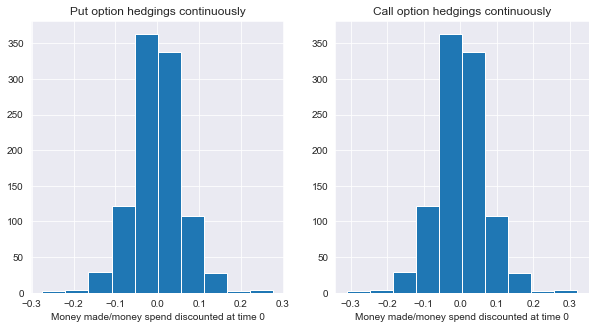

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(value_put_n_hedge)
ax1.set_xlabel("Money made/money spend discounted at time 0")
ax1.set_title("Put option hedgings continuously")

ax2.hist(value_call_n_hedge)
ax2.set_xlabel("Money made/money spend discounted at time 0")
ax2.set_title("Call option hedgings continuously")

In [65]:
print(f'Mean for put: {np.round(np.mean(value_put_n_hedge), 2)}.\nMean for call: {np.round(np.mean(value_call_n_hedge), 2)}.')
print(f'Variance for put: {np.round(np.var(value_put_n_hedge), 4)}.\nVariance for call: {np.round(np.var(value_call_n_hedge), 4)}.')

Mean for put: -0.0.
Mean for call: 0.0.
Variance for put: 0.0036.
Variance for call: 0.0047.


When delta hegding is performed continuously (at each "step" of geometric brownian motion), variance is reduced nearly to $0$. Maximum gain or loss from this strategy is approximately $20\%$ - $30\%$.

## Delta-gamma hedging

### Hedging at $t=0$
------------------------------

In [66]:
#one hedging

K = 110
K_call = 120
K_put = 100

r = 0.04

value_put_one_hedge_dg = np.zeros(1000)
value_call_one_hedge_dg = np.zeros(1000)
 
for mcs in np.arange(1000):
    
    gbm = GBM(0.2, 0.04, 100)
    
    option_market_put = Option(K, gbm, "put")
    option_market_1_gamma = Option(K_call, gbm, "call")
    
    N_call = -option_market_put.gamma()/option_market_1_gamma.gamma() #gamma_total = gamma_put + N*gamma_call = 0
    delta_0 = option_market_put.delta() + N_call*option_market_1_gamma.delta()
    
    value_put_one_hedge_dg[mcs] = np.exp(-option_market_put.r*gbm.T)*(((option_market_put.price_option() - delta_0*gbm.trajectory[0] + N_call*option_market_1_gamma.price_option())*np.exp(option_market_put.r*gbm.T) + delta_0*gbm.trajectory[-1] - option_market_put.payoff() - N_call*option_market_1_gamma.payoff())/option_market_put.price_option())
    
    option_market_call = Option(K, gbm, "call")
    option_market_2_gamma = Option(K_put, gbm, "put")
    
    N_put = -option_market_call.gamma()/option_market_2_gamma.gamma() 
    delta_0 = option_market_call.delta() + N_call*option_market_2_gamma.delta()
    
    value_call_one_hedge_dg[mcs] = np.exp(-option_market_call.r*gbm.T)*(((option_market_call.price_option() - delta_0*gbm.trajectory[0] + N_call*option_market_2_gamma.price_option())*np.exp(option_market_call.r*gbm.T) + delta_0*gbm.trajectory[-1] - option_market_call.payoff() - N_put*option_market_2_gamma.payoff())/option_market_call.price_option())
    
    

Text(0.5, 1.0, 'Call option one delta-gamma hedging')

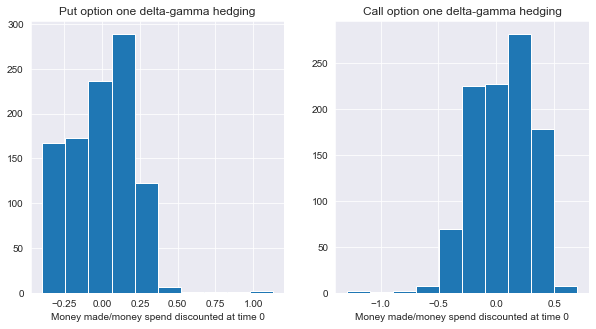

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(value_put_one_hedge_dg)
ax1.set_xlabel("Money made/money spend discounted at time 0")
ax1.set_title("Put option one delta-gamma hedging")

ax2.hist(value_call_one_hedge_dg)
ax2.set_xlabel("Money made/money spend discounted at time 0")
ax2.set_title("Call option one delta-gamma hedging")

In [68]:
print(f'Mean for put: {np.round(np.mean(value_put_one_hedge_dg), 2)}.\nMean for call: {np.round(np.mean(value_call_one_hedge_dg), 2)}.')
print(f'Variance for put: {np.round(np.var(value_put_one_hedge_dg), 4)}.\nVariance for call: {np.round(np.var(value_call_one_hedge_dg), 4)}.')

Mean for put: -0.0.
Mean for call: 0.05.
Variance for put: 0.0419.
Variance for call: 0.0624.


Althought delta-gamma hedging was applied only once, at $t=0$, variance has been drastically reduced (approximately $10$ times more than in a comparable scenario with only delta hedging).

### Hedging at $t=0$ and $t=1$
___________________

In [69]:
#two hedgings

K = 110
K_call = 120
K_put = 100

r = 0.04

value_put_two_hedge_dg = np.zeros(1000)
value_call_two_hedge_dg = np.zeros(1000)
 
for mcs in np.arange(1000):
    
    gbm = GBM(0.2, 0.04, 100)
    
    #put option
    option_market_put = Option(K, gbm, "put")
    option_market_1_gamma = Option(K_call, gbm, "call")
    
    N_call = -option_market_put.gamma()/option_market_1_gamma.gamma() #gamma_total = gamma_put + N*gamma_call = 0
    delta_0 = option_market_put.delta() + N_call*option_market_1_gamma.delta()
    
    N_call2 = -option_market_put.gamma(1)/option_market_1_gamma.gamma(1)
    delta_1 = option_market_put.delta(1) + N_call2*option_market_1_gamma.delta(1)
    
    assets_bought_compounded_put = delta_0*gbm.trajectory[0]*np.exp(r*gbm.T) + (delta_1 - delta_0)*gbm.trajectory[int(np.round(1/gbm.dt))]*np.exp(r*(gbm.T-1))
    options_bought_compounded_put = N_call*option_market_1_gamma.price_option(0)*np.exp(r*gbm.T) + (N_call2 - N_call)*option_market_1_gamma.price_option(1)*np.exp(r*(gbm.T-1))
    
    value_put_two_hedge_dg[mcs] = np.exp(-option_market_put.r*gbm.T)*(((option_market_put.price_option())*np.exp(option_market_put.r*gbm.T) - assets_bought_compounded_put + options_bought_compounded_put + delta_1*gbm.trajectory[-1] - option_market_put.payoff() - N_call2*option_market_1_gamma.payoff())/option_market_put.price_option())
    
    #call option
    option_market_call = Option(K, gbm, "call")
    option_market_2_gamma = Option(K_put, gbm, "put")
    
    N_put = -option_market_call.gamma()/option_market_2_gamma.gamma() 
    delta_0_2 = option_market_call.delta() + N_put*option_market_2_gamma.delta()
    
    N_put2 = -option_market_call.gamma(1)/option_market_2_gamma.gamma(1) 
    delta_1_2 = option_market_call.delta(1) + N_put2*option_market_2_gamma.delta(1)
    
    assets_bought_compounded_call = delta_0_2*gbm.trajectory[0]*np.exp(r*gbm.T) + (delta_1_2 - delta_0_2)*gbm.trajectory[int(np.round(1/gbm.dt))]*np.exp(r*(gbm.T-1))
    options_bought_compounded_call = N_put*option_market_2_gamma.price_option(0)*np.exp(r*gbm.T) + (N_put2 - N_put)*option_market_2_gamma.price_option(1)*np.exp(r*(gbm.T-1))
    
    value_call_two_hedge_dg[mcs] = np.exp(-option_market_call.r*gbm.T)*(((option_market_call.price_option())*np.exp(option_market_call.r*gbm.T) - assets_bought_compounded_call + options_bought_compounded_call + delta_1_2*gbm.trajectory[-1] - option_market_call.payoff() - N_put2*option_market_2_gamma.payoff())/option_market_call.price_option())
    
    

Text(0.5, 1.0, 'Call option two delta-gamma hedgings')

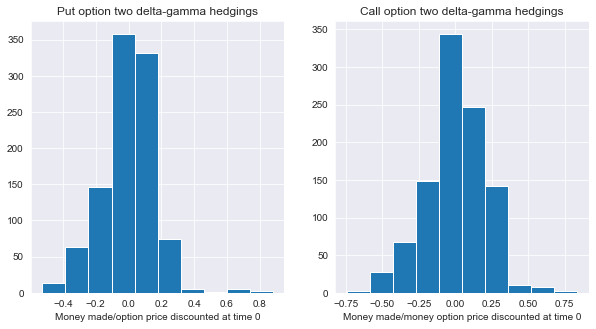

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(value_put_two_hedge_dg)
ax1.set_xlabel("Money made/option price discounted at time 0")
ax1.set_title("Put option two delta-gamma hedgings")

ax2.hist(value_call_two_hedge_dg)
ax2.set_xlabel("Money made/money option price discounted at time 0")
ax2.set_title("Call option two delta-gamma hedgings")

In [71]:
print(f'Mean for put: {np.round(np.mean(value_put_two_hedge_dg), 2)}.\nMean for call: {np.round(np.mean(value_call_two_hedge_dg), 2)}.')
print(f'Variance for put: {np.round(np.var(value_put_two_hedge_dg), 4)}.\nVariance for call: {np.round(np.var(value_call_two_hedge_dg), 4)}.')

Mean for put: -0.0.
Mean for call: 0.0.
Variance for put: 0.0255.
Variance for call: 0.0423.


After applying an additional hedging at $t=1$, the money made/option price distribution became more concentrated around $0$.

### Continuous delta-gamma hedging
---------------------------

In [72]:
def delta_gamma_hedging_cont(mc_steps, K1, K2, option_type_1, option_type_2, mu, sigma, S0, dt=0.01, T=2, real_data=False):
    
    value_hedge_dg = np.zeros(mc_steps)
    
    for mc in np.arange(mc_steps):
        
        if not real_data:
            gbm = GBM(sigma, mu, S0, dt=dt, T=T) 
        else:
            gbm = RealData(historical_data[["Close"]].iloc[-252:], mu)
            
        option_1 = Option(K1, gbm, option_type_1) #base option
        option_2 = Option(K2, gbm, option_type_2) #option to sell or buy to have gamma neutral portfolio
        
        v0 = option_1.price_option(0)
        N_0 = -option_1.gamma()/option_2.gamma() 
        delta_0 = option_1.delta() + N_0*option_2.delta()
        
        m0 = v0 - delta_0*gbm.trajectory[0] + N_0*option_2.price_option()
        
        delta_prev = delta_0
        m_prev = m0
        N_prev = N_0
        
        for i in np.arange(1, len(gbm.trajectory)):
            
            if option_2.gamma(i*dt) != 0:
                N_t = -option_1.gamma(i*dt)/option_2.gamma(i*dt) #how many other options we should have sold to have neurtal gamma (N_T*gamma(2) + gamma(1) = 0)
            else:
                N_t = 0 #if division by zero, take zero
                
            delta_t = option_1.delta(i*dt) + N_t*option_2.delta(i*dt) #how many assets we should have in our portfolio to have neutral delta
            
            ut = delta_t - delta_prev #new assets to buy
            wt = N_t - N_prev #new options to sell
            mt = np.exp(r*dt)*m_prev - ut*gbm.trajectory[i] + wt*option_2.price_option(i*dt)
            
            m_prev = mt
            delta_prev = delta_t
            N_prev = N_t
            
        value_hedge_dg[mc] = np.exp(-r*gbm.T)*(mt - option_1.payoff() + delta_prev*gbm.trajectory[-1] - N_prev*option_2.payoff())/v0
        
    return value_hedge_dg

In [73]:
put_values_dg = delta_gamma_hedging_cont(1000, 110, 120, "put", "call", 0.04, 0.2, 100, dt=0.01, T=2)
call_values_dg = delta_gamma_hedging_cont(1000, 110, 100, "call", "put", 0.04, 0.2, 100, dt=0.01, T=2)

Text(0.5, 1.0, 'Call option hedgings continuously')

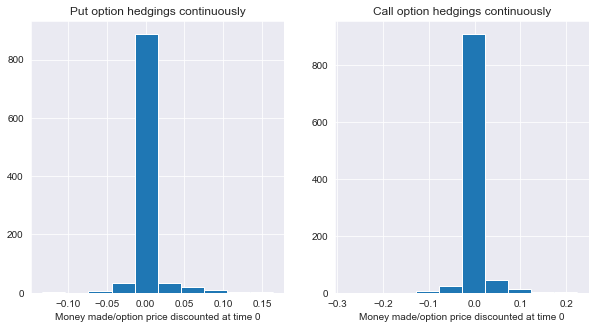

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(put_values_dg)
ax1.set_xlabel("Money made/option price discounted at time 0")
ax1.set_title("Put option hedgings continuously")

ax2.hist(call_values_dg)
ax2.set_xlabel("Money made/option price discounted at time 0")
ax2.set_title("Call option hedgings continuously")

In [75]:
print(f'Mean for put: {np.round(np.mean(put_values_dg), 2)}.\nMean for call: {np.round(np.mean(call_values_dg), 2)}.')
print(f'Variance for put: {np.round(np.var(put_values_dg), 4)}.\nVariance for call: {np.round(np.var(call_values_dg), 4)}.')

Mean for put: 0.0.
Mean for call: 0.0.
Variance for put: 0.0004.
Variance for call: 0.0005.


After applying delta-gamma hedging at each step of the geometric Brownian motion, the distribution becomes highly concentrated around zero, with both variance and mean close to zero. Maximum gain and loss is approximately 10%.

### Delta-gamma hedging for real assets
------------------

In [76]:
kgh_stock = yf.Ticker('KGH.WA') #we have chosen KGHM assets
historical_data = kgh_stock.history(period="2y")

df = RealData(historical_data[["Close"]].iloc[-252:], 0.03) #last year with r=0.03
print(f'Volatility of the asset: {np.round(df.sigma,2)}.')

Volatility of the asset: 0.36.


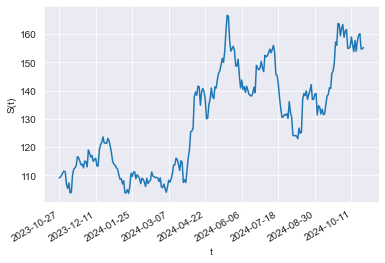

In [77]:
df.plot()

#### Portfolio with no hedging

In [78]:
#no hedging

K = 110
r = 0.03
gbm = df
    
option_market_put = Option(K, gbm, "put")
put_no_hedge = np.exp(-option_market_put.r*gbm.T)*(((option_market_put.price_option())*np.exp(option_market_put.r*gbm.T) - option_market_put.payoff())/option_market_put.price_option())
    
option_market_call = Option(K, gbm, "call")
call_no_hedge = np.exp(-option_market_call.r*gbm.T)*(((option_market_call.price_option())*np.exp(option_market_call.r*gbm.T) - option_market_call.payoff())/option_market_call.price_option())

In [79]:
print(f'Money made/option price for put option with K = 110: {np.round(put_no_hedge, 2)}.') #payoff is zero, so we get option price

Money made/option price for put option with K = 110: 1.0.


In [80]:
print(f'Money made/option price for call option with K = 110: {np.round(call_no_hedge, 2)}.')

Money made/option price for call option with K = 110: -1.66.


#### Values with continuos delta-gamma hedging


In [81]:
put_values_dg = delta_gamma_hedging_cont(1, 120, 130, "put", "call", 0.04, 0.2, 100, dt=df.dt, T=1, real_data=True)
call_values_dg = delta_gamma_hedging_cont(1, 120, 110, "call", "put", 0.04, 0.2, 100, dt=df.dt, T=1, real_data=True)

In [82]:
print(f'Money made/option price for put option with K = 110 and delta-gamma hedging: {np.round(put_values_dg[0], 2)}.')

Money made/option price for put option with K = 110 and delta-gamma hedging: -0.04.


In [83]:
print(f'Money made/option price for call option with K = 110 and delta-gamma hedging: {np.round(call_values_dg[0], 2)}.')

Money made/option price for call option with K = 110 and delta-gamma hedging: 0.08.


The values are close to zero, indicating that delta-gamma hedging is performing as expected.